# Project 4
**Student:** Matthew Malueg

**Task**
- Below we will examine a data set on car insurance claims, and analyze information about drives who have or have not made a claim.
- Examination of customer info may reveal patterns or trends about who is likely to make a claim, allowing for more accurate risk-assessment for stakeholders.
- We will begin by examining, cleaning, and formatting the data before moving on to visualizing and assessing model results.

### Imports and Loading

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

from sklearn import set_config
set_config(transform_output='pandas',
           display='diagram')

In [2]:
# Visualization functions
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
    
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # Value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define most common value
  most_common_val = val_counts.index[0]
  # Define most common val frequency
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

def explore_numeric(df2, x, figsize=(6,5)):
  ## Save null value counts and percent
  null_count = df2[x].isna().sum()
  null_perc = null_count/len(df)* 100

  ## Make figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram (top)
  sns.histplot(data=df2, x=x, ax=axes[0])

  # Boxplot (bottom)
  sns.boxplot(data=df2, x=x, ax=axes[1])

  ## Title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()
  # Ensure plot is shown before message
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # Get the most most common value and count the # and %
  most_common_val_count = df2[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # Notify if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [3]:
# Evaluation Functions
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classifiication report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = '-'*70
  print(header, f'Classification Metrics: {label}', header, sep='\n')
  print(report)
  ## CONFUSION MATRICIES SUBPLOT
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # Create a confusion matrix of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          normalize=None, cmap='gist_gray',
                                          colorbar=colorbar,
                                          ax = axes[0],)
  axes[0].set_title('Raw Counts')
  # Create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                          normalize=normalize, cmap=cmap,
                                          colorbar=colorbar,
                                          ax = axes[1],)
  axes[1].set_title('Normalized Confusion Matrix')
  fig.tight_layout()
  plt.show()
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict=False,
                            cmap_train='Blues', cmap_test='Reds',
                            colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, output_dict=True,
                                         figsize=figsize, colorbar=colorbar,
                                         cmap=cmap_train, label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, output_dict=True,
                                        figsize=figsize, colorbar=colorbar,
                                        cmap=cmap_test, label='Test Data')
  if output_dict==True:
    # Store results in a dataframe if output_dict is True
    results_dict = {'train': results_train,
                    'test':  results_test}
    return results_dict

In [4]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

### Examine Data

In [5]:
# Load the dataset
df = pd.read_csv("Data/Car_Insurance_Claim.csv")
df = df.set_index('ID')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [6]:
df.isna().sum()

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [7]:
df.duplicated().sum()

12

In [8]:
df.nunique()

AGE                       4
GENDER                    2
RACE                      2
DRIVING_EXPERIENCE        4
EDUCATION                 3
INCOME                    4
CREDIT_SCORE           9018
VEHICLE_OWNERSHIP         2
VEHICLE_YEAR              2
MARRIED                   2
CHILDREN                  2
POSTAL_CODE               4
ANNUAL_MILEAGE           21
VEHICLE_TYPE              2
SPEEDING_VIOLATIONS      21
DUIS                      7
PAST_ACCIDENTS           15
OUTCOME                   2
dtype: int64

In [9]:
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  10000 non-null  object 
 1   GENDER               10000 non-null  object 
 2   RACE                 10000 non-null  object 
 3   DRIVING_EXPERIENCE   10000 non-null  object 
 4   EDUCATION            10000 non-null  object 
 5   INCOME               10000 non-null  object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    10000 non-null  float64
 8   VEHICLE_YEAR         10000 non-null  object 
 9   MARRIED              10000 non-null  float64
 10  CHILDREN             10000 non-null  float64
 11  POSTAL_CODE          10000 non-null  int64  
 12  ANNUAL_MILEAGE       9043 non-null   float64
 13  VEHICLE_TYPE         10000 non-null  object 
 14  SPEEDING_VIOLATIONS  10000 non-null  int64  
 15  DUIS                 10000 non

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0


In [10]:
df.describe()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [11]:
df.describe(exclude='number')

,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,VEHICLE_YEAR,VEHICLE_TYPE
count,10000,10000,10000,10000,10000,10000,10000,10000
unique,4,2,2,4,3,4,2,2
top,26-39,female,majority,0-9y,high school,upper class,before 2015,sedan
freq,3063,5010,9012,3530,4157,4336,6967,9523


- The dataset has 12 duplicated rows, and contains null values for credit score and annual mileage.
- Some features have only two unique values, but are still object type. These can be converted to binary numeric values.
    - Gender
    - Race
    - Vehicle Year
- Postal Code will need to be a categorical feature.
- Vehicle Ownership, Outcome, Married, Children, and Annual Mileage can be changed to int.
- Driving Experience, Education, and Income will be ordinal features.
- Credit score has a mean of 0.516, and a max of 0.961. Most credit score rating systems will not have a score above 850, so these are not simply calculated scores left as a decimal. There is no explanation or data dictionary available for the dataset.

### Cleaning dataset

In [12]:
# Drop duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [13]:
# Rename columns and replace values as needed
rename_dict = {'GENDER': 'Is Female', 'RACE': 'Racial Majority', 'VEHICLE_YEAR': 'Vehicle Post 2015'}
df = df.rename(rename_dict, axis=1)
df.head(3)

,AGE,Is Female,Racial Majority,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,Vehicle Post 2015,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,,,,,,,,,,,,,,,,,,
569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0


In [14]:
## Replace values in columns to match new names
# Gender
df['Is Female'] = df['Is Female'].str.replace('female', '1')
df['Is Female'] = df['Is Female'].str.replace('male', '0')
df['Is Female'] = df['Is Female'].astype(int)

In [15]:
# Race
df['Racial Majority'] = df['Racial Majority'].str.replace('majority', '1')
df['Racial Majority'] = df['Racial Majority'].str.replace('minority', '0')
df['Racial Majority'] = df['Racial Majority'].astype(int)

In [16]:
# Model year
df['Vehicle Post 2015'] = df['Vehicle Post 2015'].str.replace('after 2015', '1')
df['Vehicle Post 2015'] = df['Vehicle Post 2015'].str.replace('before 2015', '0')
df['Vehicle Post 2015'] = df['Vehicle Post 2015'].astype(int)

In [17]:
# Postal code
df['POSTAL_CODE'] = df['POSTAL_CODE'].astype(str)

In [18]:
# Convert cols to int
df[['VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'OUTCOME']] = df[['VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'OUTCOME']].astype(int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9988 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  9988 non-null   object 
 1   Is Female            9988 non-null   int32  
 2   Racial Majority      9988 non-null   int32  
 3   DRIVING_EXPERIENCE   9988 non-null   object 
 4   EDUCATION            9988 non-null   object 
 5   INCOME               9988 non-null   object 
 6   CREDIT_SCORE         9018 non-null   float64
 7   VEHICLE_OWNERSHIP    9988 non-null   int32  
 8   Vehicle Post 2015    9988 non-null   int32  
 9   MARRIED              9988 non-null   int32  
 10  CHILDREN             9988 non-null   int32  
 11  POSTAL_CODE          9988 non-null   object 
 12  ANNUAL_MILEAGE       9034 non-null   float64
 13  VEHICLE_TYPE         9988 non-null   object 
 14  SPEEDING_VIOLATIONS  9988 non-null   int64  
 15  DUIS                 9988 non-n

In [20]:
# Save cleaned dataframe
df.to_csv('Data/Clean_Car_Insurance_Claim.csv', index=True)

### Perform Exploratory Visualizations

**Fill Null Values for Visualizations**

In [21]:
df_vis = df.copy()
df_vis.isna().sum()

AGE                      0
Is Female                0
Racial Majority          0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           970
VEHICLE_OWNERSHIP        0
Vehicle Post 2015        0
MARRIED                  0
CHILDREN                 0
POSTAL_CODE              0
ANNUAL_MILEAGE         954
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64

In [22]:
# Impute Credit score
df_vis['CREDIT_SCORE'].fillna(df_vis['CREDIT_SCORE'].mean(), inplace=True)
df_vis['CREDIT_SCORE'].isna().sum()

0

In [23]:
# Impute Annual mileage
df_vis['ANNUAL_MILEAGE'].fillna(df_vis['ANNUAL_MILEAGE'].mean(), inplace=True)
df_vis['ANNUAL_MILEAGE'].isna().sum()

0

**Create Visuals for Numeric Features**

In [24]:
df_vis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9988 entries, 569520 to 442696
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AGE                  9988 non-null   object 
 1   Is Female            9988 non-null   int32  
 2   Racial Majority      9988 non-null   int32  
 3   DRIVING_EXPERIENCE   9988 non-null   object 
 4   EDUCATION            9988 non-null   object 
 5   INCOME               9988 non-null   object 
 6   CREDIT_SCORE         9988 non-null   float64
 7   VEHICLE_OWNERSHIP    9988 non-null   int32  
 8   Vehicle Post 2015    9988 non-null   int32  
 9   MARRIED              9988 non-null   int32  
 10  CHILDREN             9988 non-null   int32  
 11  POSTAL_CODE          9988 non-null   object 
 12  ANNUAL_MILEAGE       9988 non-null   float64
 13  VEHICLE_TYPE         9988 non-null   object 
 14  SPEEDING_VIOLATIONS  9988 non-null   int64  
 15  DUIS                 9988 non-n

In [25]:
# List categorical features
cat_feats = ['AGE', 'Is Female', 'Racial Majority', 'DRIVING_EXPERIENCE', 'EDUCATION', 
             'INCOME', 'VEHICLE_OWNERSHIP', 'Vehicle Post 2015', 'MARRIED', 'CHILDREN', 
             'POSTAL_CODE', 'VEHICLE_TYPE', 'OUTCOME']
# List numeric features
num_feats = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']

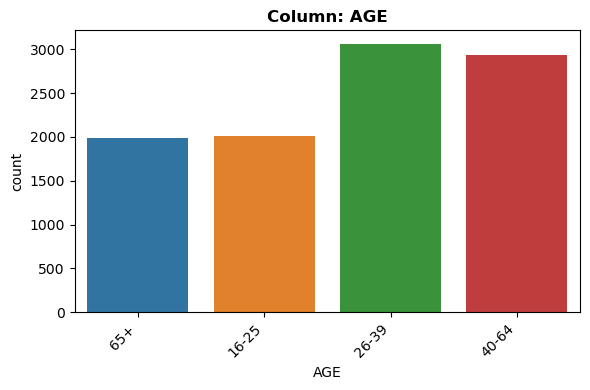

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '26-39' occurs 3062 times (30.66%)
- Not constant or quasi-constant.


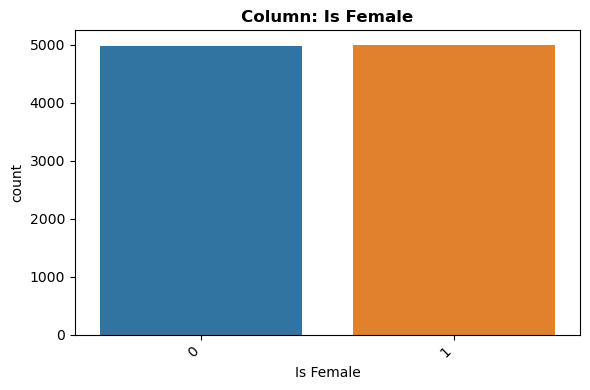

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 5003 times (50.09%)
- Not constant or quasi-constant.


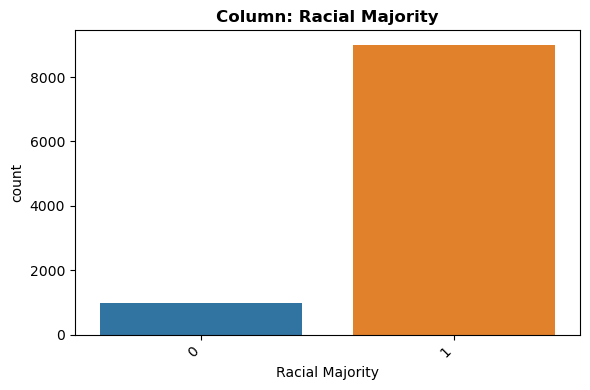

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 9000 times (90.11%)
- Not constant or quasi-constant.


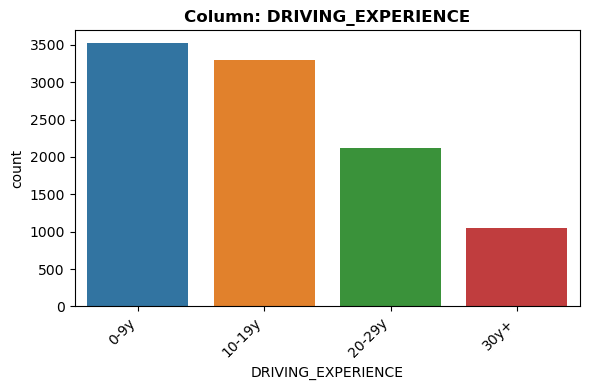

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '0-9y' occurs 3519 times (35.23%)
- Not constant or quasi-constant.


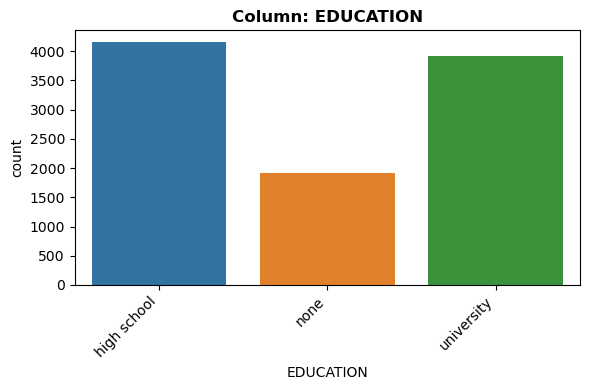

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'high school' occurs 4151 times (41.56%)
- Not constant or quasi-constant.


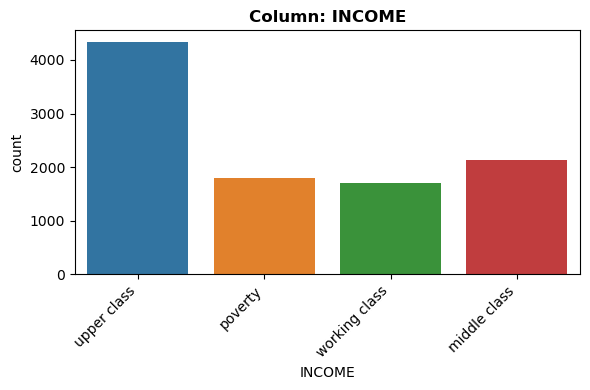

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'upper class' occurs 4335 times (43.4%)
- Not constant or quasi-constant.


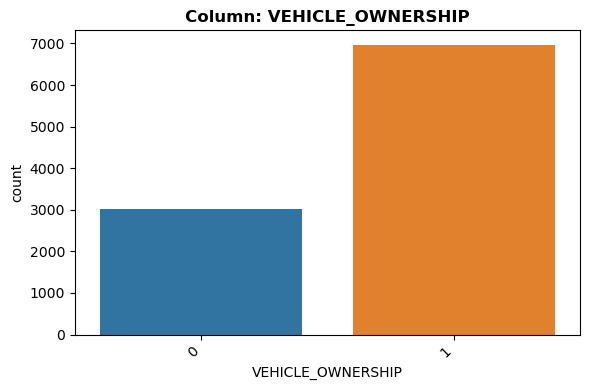

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 6967 times (69.75%)
- Not constant or quasi-constant.


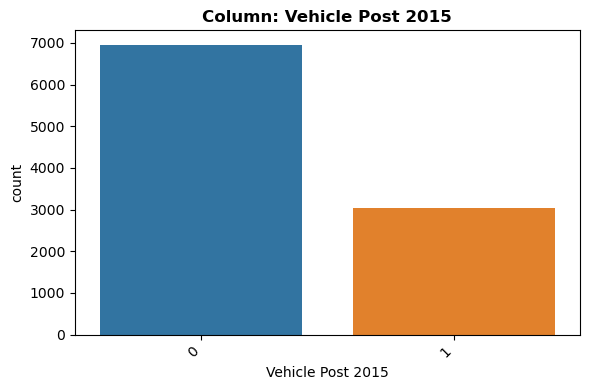

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 6955 times (69.63%)
- Not constant or quasi-constant.


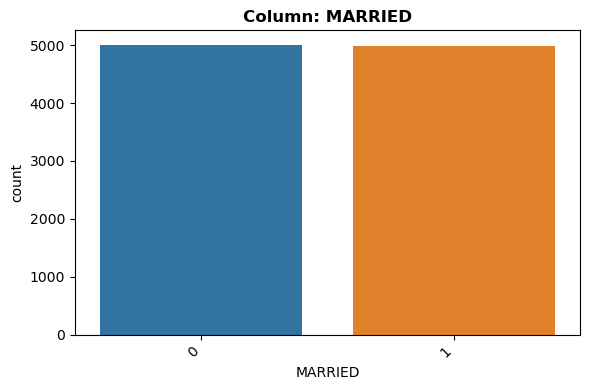

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 5007 times (50.13%)
- Not constant or quasi-constant.


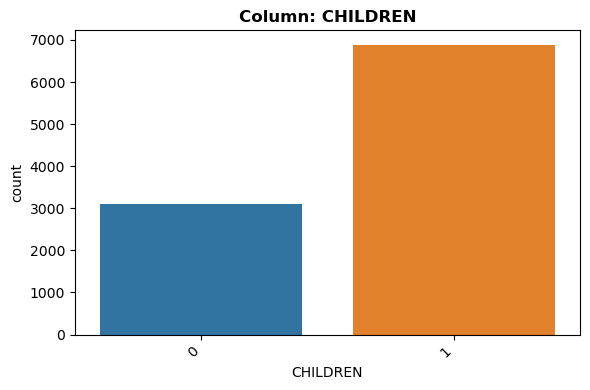

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '1' occurs 6885 times (68.93%)
- Not constant or quasi-constant.


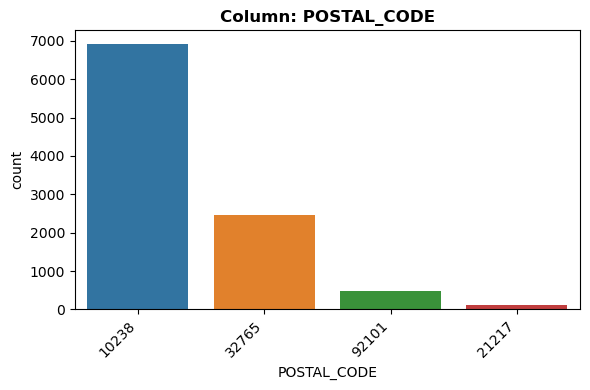

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: '10238' occurs 6929 times (69.37%)
- Not constant or quasi-constant.


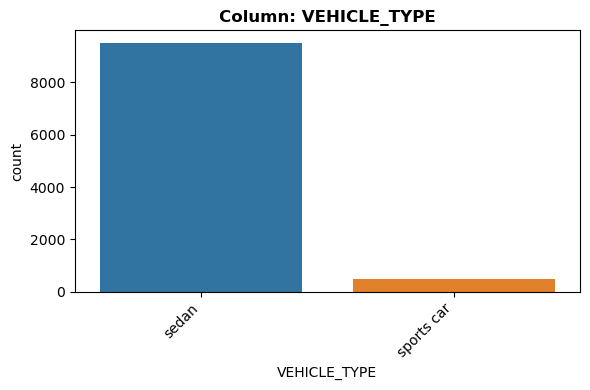

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'sedan' occurs 9511 times (95.22%)
- Not constant or quasi-constant.


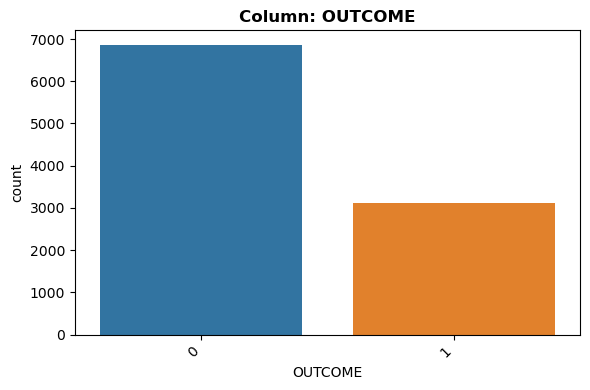

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 6864 times (68.72%)
- Not constant or quasi-constant.


In [26]:
for feat in cat_feats:
    explore_categorical(df_vis, feat)

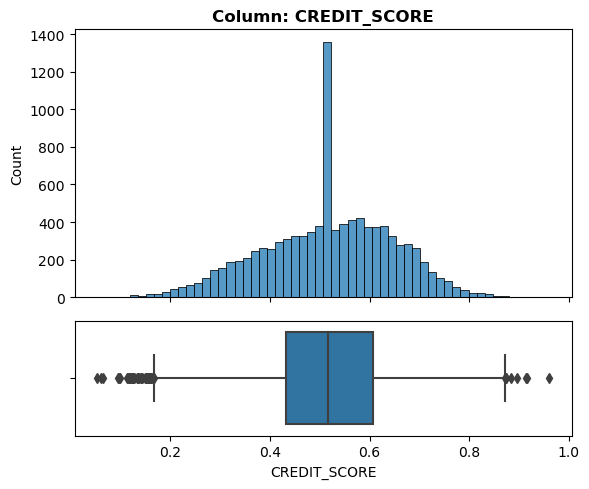

- NaN's Found: 0 (0.0%)
- Unique Values: 9018
- Most common value: '0.5158128096027911' occurs 970 times (9.71%)
- Not constant or quasi-constant.


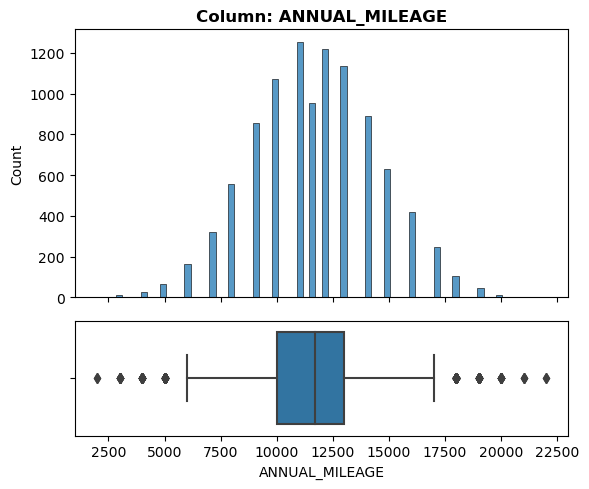

- NaN's Found: 0 (0.0%)
- Unique Values: 21
- Most common value: '11000.0' occurs 1253 times (12.55%)
- Not constant or quasi-constant.


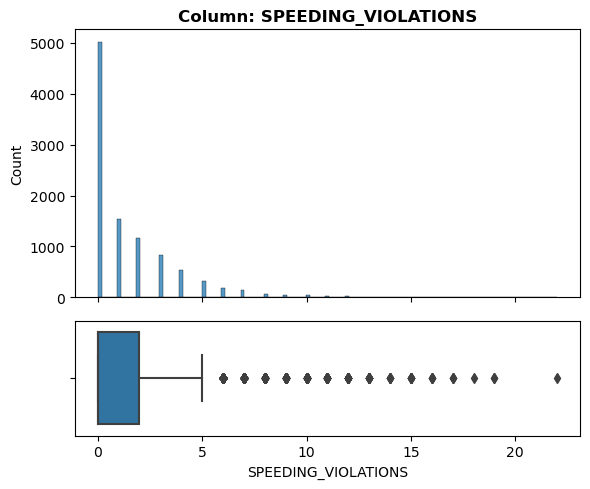

- NaN's Found: 0 (0.0%)
- Unique Values: 21
- Most common value: '0' occurs 5017 times (50.23%)
- Not constant or quasi-constant.


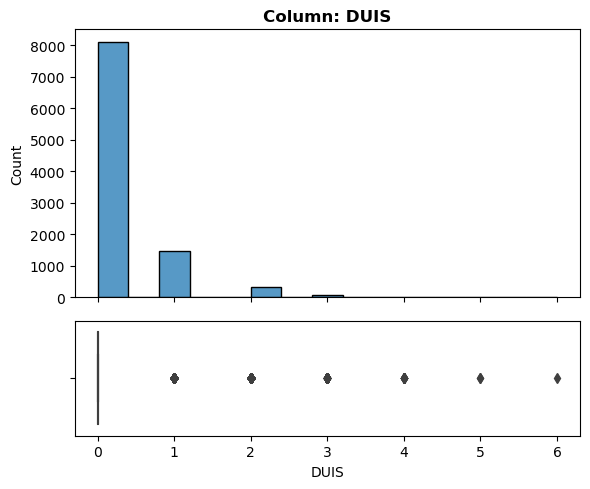

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: '0' occurs 8106 times (81.16%)
- Not constant or quasi-constant.


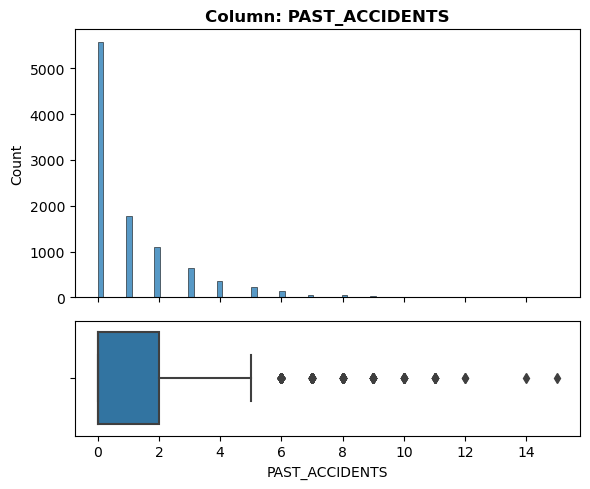

- NaN's Found: 0 (0.0%)
- Unique Values: 15
- Most common value: '0' occurs 5573 times (55.8%)
- Not constant or quasi-constant.


In [27]:
for feat in num_feats:
    explore_numeric(df_vis, feat)

**Observations**
- Only around 70 of individuals have filed a claim.
- Nearly all the vehicles were sedans, greatly outnumbering the only other option, sports car.
- Individuals with an income level in the upper class made up almost half the data, with the rest distributed fairly evenly among middle class, working class, and poverty.
- Individuals were about twice as likely to own their vehicle than not.
- Only about 1/3 of the vehicles were 2015 or newer.
- Of four postal codes, 10238 represents about 70% of the data. 32765 accounts for over 20%, with the remaining few left in 92101 and 21217.
- Credit score and annual mileage are distributed about evenly.
- Recorded violations and accidents are highest at zero and as the number of incidents rises, the number of data points drops quickly.

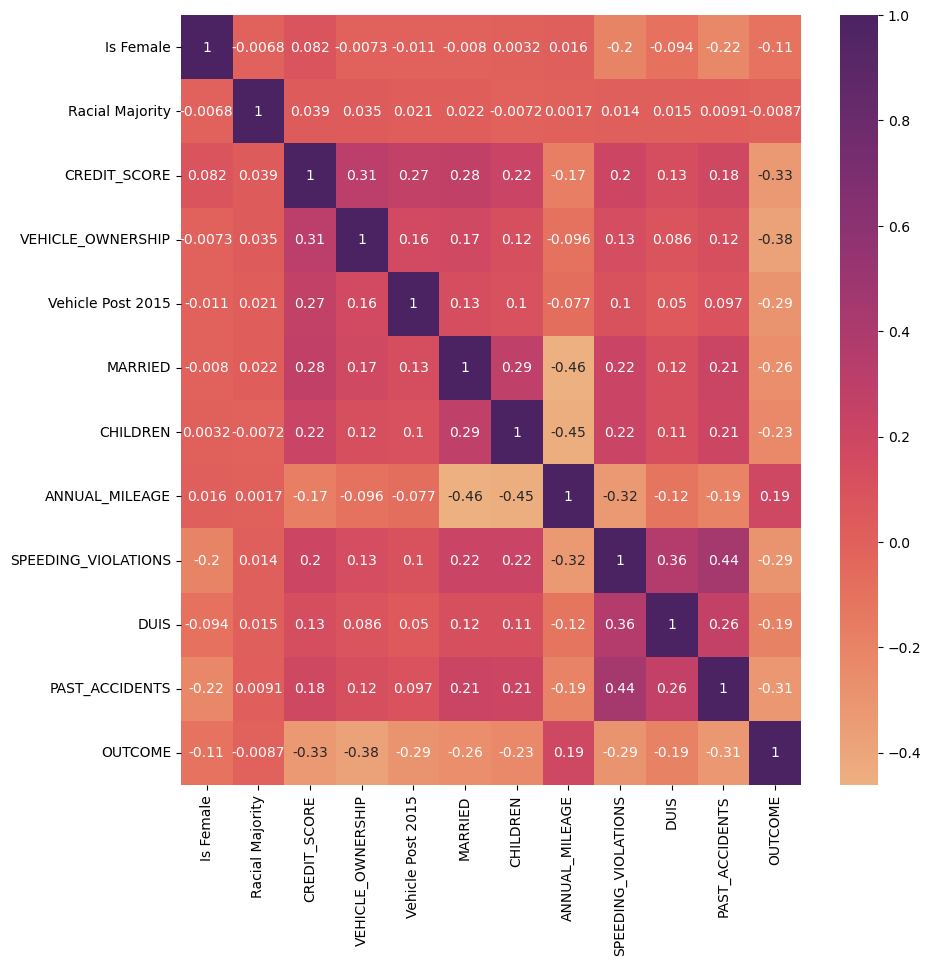

In [28]:
# Obtain correlation heatmap
corr = df.corr(numeric_only=True)
corr.round(2)

plt.figure(figsize=(10,10))
ax= sns.heatmap(corr, annot=True, cmap='flare');

**Observations**
- There is an apparent negative correlation between amount of miles travelled annually with being married and/or having children.
- There is a positive correlation between having speeding tickets and prior accidents on record.

### Preprocessing Data and Choosing a Model

#### Preprocess

In [29]:
# Perform TTS on dataframe and preprocess training data
target = 'OUTCOME'
y = df[target]
X = df.drop(columns=target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Define lists of columns**

In [30]:
## Create pipelines for preprocessing
# Ordinal cols
ord_cols = X_train[['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME']].columns
ord_cols

Index(['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME'], dtype='object')

In [31]:
# Categorical cols
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
cat_cols

Index(['POSTAL_CODE', 'VEHICLE_TYPE'], dtype='object')

In [32]:
# Numeric cols
num_cols = X_train.select_dtypes('number').columns
num_cols

Index(['Is Female', 'Racial Majority', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'Vehicle Post 2015', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')

**Make pipelines**

In [33]:
## Create ordinal pipeline
# Specify order of ordinal features
age_order = ['16-25', '26-39', '40-64', '65+']
exp_order = ['0-9y', '10-19y', '20-29y', '30y+']
edu_order = ['none', 'high school', 'university']
inc_order = ['poverty', 'working class', 'middle class', 'upper class']

# Create order list
ordinal_cat_orders = [age_order, exp_order, edu_order, inc_order]

# Instantiate scaler, transformers
ord_scaler = StandardScaler()
ord_enc = OrdinalEncoder(categories=ordinal_cat_orders)

# Create pipeline
ord_pipe = make_pipeline(ord_enc, ord_scaler)
ord_tuple = ('ordinal', ord_pipe, ord_cols)

In [34]:
## Create numeric pipeline
# Instantiate imputer
simple_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Create pipeline
num_pipe = make_pipeline(scaler, simple_imputer)
num_tuple = ('numeric', num_pipe, num_cols)

In [35]:
## Create categorical pipeline
# Instatntiate ohe
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_pipe = make_pipeline(ohe)
cat_tuple = ('categorical', cat_pipe, cat_cols)

In [36]:
# Create transformer
col_transformer = ColumnTransformer([ord_tuple, num_tuple, cat_tuple],
                                    verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['16-25',
                                                                              '26-39',
                                                                              '40-64',
                                                                              '65+'],
                                                                             ['0-9y',
                                                                              '10-19y',
                                                                              '20-29y',
                                                                              '30y+'],
                                                                             ['none',
                                                                              'high '
                                                                              'school',
                                                                              'university'],
                                                                             ['poverty',
                                                                              'working '
                                                                              'class',
                                                                              'middle '
                                                                              'class',
                                                                              'upper '
                                                                              'class']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['AGE', 'DRIVING_EXPERIENCE', 'EDUCATI...
                                 Index(['Is Female', 'Racial Majority', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'Vehicle Post 2015', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['POSTAL_CODE', 'VEHICLE_TYPE'], dtype='object'))],
                  verbose_feature_names_out=False)

#### Fit and transform

In [37]:
# Fit and transform using col transformer
X_train_tf = col_transformer.fit_transform(X_train)
X_test_tf = col_transformer.transform(X_test)

In [38]:
# Check for target balance
y_train.value_counts(1)

0    0.686691
1    0.313309
Name: OUTCOME, dtype: float64

In [39]:
# Rectify target balance
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)

In [40]:
# Recheck target balabnce
y_train_sm.value_counts(1)

1    0.5
0    0.5
Name: OUTCOME, dtype: float64

In [41]:
# Instantiate a default random forest with a random state for reproductibility
dt_clf = DecisionTreeClassifier()
# Fit on the training data
dt_clf.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier()

----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5144
           1       1.00      1.00      1.00      5144

    accuracy                           1.00     10288
   macro avg       1.00      1.00      1.00     10288
weighted avg       1.00      1.00      1.00     10288



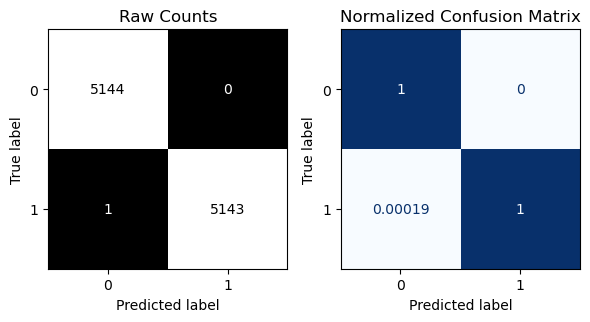


----------------------------------------------------------------------
Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1720
           1       0.65      0.69      0.67       777

    accuracy                           0.79      2497
   macro avg       0.75      0.76      0.75      2497
weighted avg       0.79      0.79      0.79      2497



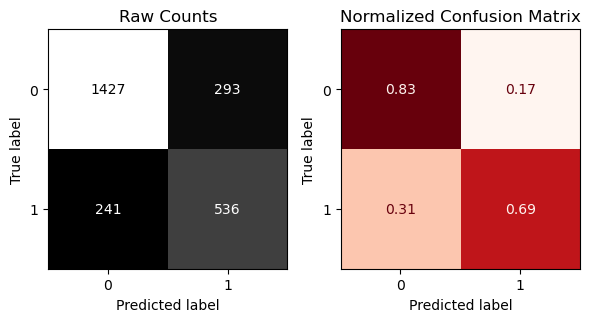

In [42]:
# Evaluate with the custom function
evaluate_classification(dt_clf, X_train_sm, y_train_sm, X_test_tf, y_test)

#### Visualize top 10 features

In [43]:
# Calculate feature permutation importances
importances = permutation_importance(dt_clf, X_train_sm, y_train_sm)
# Create a Series of Feature Importances
importances_df = pd.Series(importances['importances_mean'], index=dt_clf.feature_names_in_)
importances_df.sort_values(ascending=False).head(10)

DRIVING_EXPERIENCE    0.273523
VEHICLE_OWNERSHIP     0.135789
CREDIT_SCORE          0.125816
ANNUAL_MILEAGE        0.121753
Vehicle Post 2015     0.101439
Is Female             0.100875
POSTAL_CODE_10238     0.100369
INCOME                0.080696
AGE                   0.058029
EDUCATION             0.055035
dtype: float64

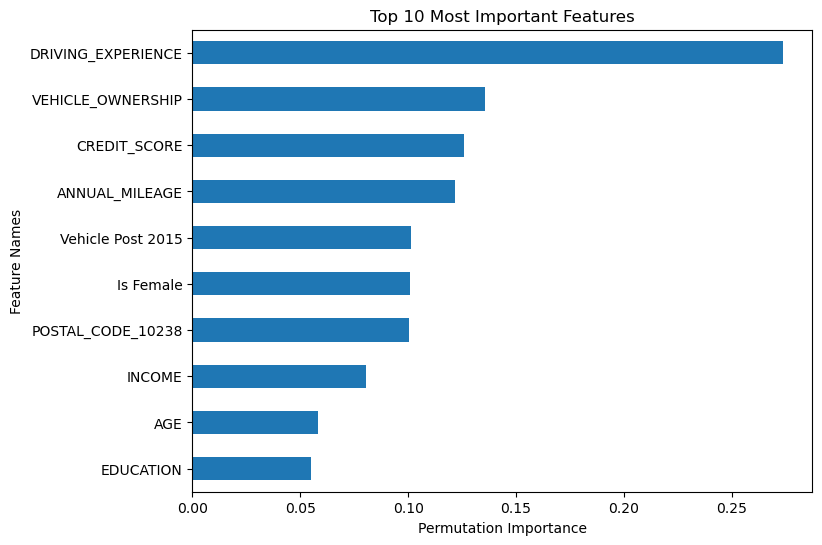

In [44]:
# Visualize the top 10 permutation importances
ax = plot_importance(importances_df, top_n=10)
ax.set(xlabel='Permutation Importance');

- Most of these features seem like logical candidates for influencing likelihood of an insurance claim. One drawback of looking at these importances is not knowing if the impact is postive or negative, but some guesses could be made applying a little common sense.
- Having a good credit score likely implies responsibility, leading to less reckless behavior and fewer accidents, and being less likely to file a claim.
- Having higher annual mileage gives more opportunities for an accident, as does lifetime driving experience. While at first thought a more experienced driver may be more cautious and better able to avoid accidents, getting in even a small accident could just be a matter of time, and decades of driving will likely result in a reportable incident.
- Having a newer vehicle, made post 2015, might make someone more likely to file a claim if damage occurs. On an older car, the driver may not consider it worth their time and having the incident on record, and simply not report it.

### Explanatory Visualizations

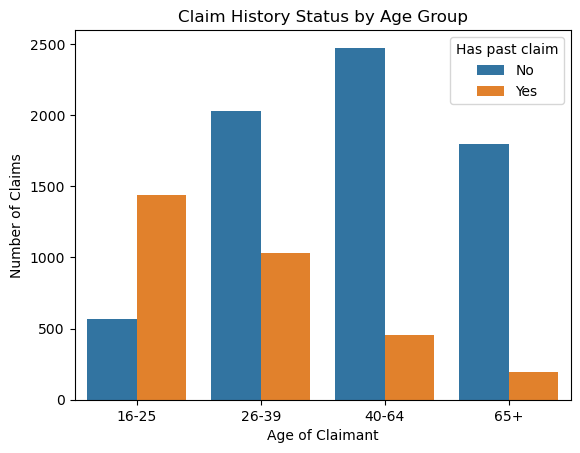

In [45]:
# Multivariate countplot with a hue argument
ax = sns.countplot(data=df, x='AGE', hue='OUTCOME',
                  order = ['16-25', '26-39', '40-64', '65+'])
ax.set_xlabel('Age of Claimant')
ax.set_ylabel('Number of Claims')
ax.set_title('Claim History Status by Age Group')

plt.legend(title='Has past claim', labels=['No', 'Yes']);

- It would seem younger, inexperienced drivers are much more likely to have made a claim with their insurance company than not, being the only age demographic where claims outnumber no-claims. Despite having a lower total number of drivers than older age groups, the absolute number of claims is also higher. There is a clear trend of fewer total reported claims as age increases.
- There is a similar but slightly different trend as well, showing that the number of drivers with no claims rises with age, but peaks at 40-64 before declining again. This indicates fewer older drivers on the road in total, accounting for some of the decrease in claims made.

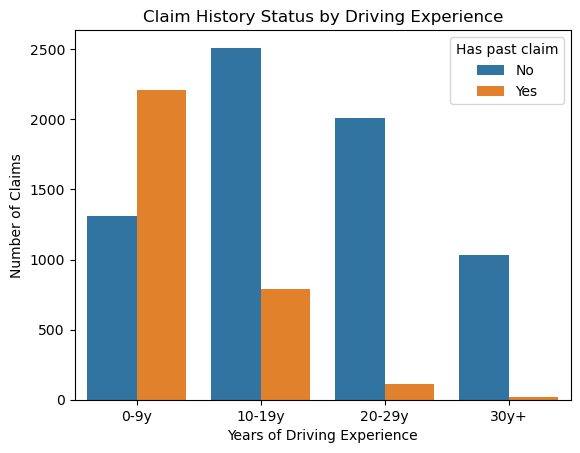

In [46]:
# Multivariate countplot with a hue argument
ax = sns.countplot(data=df, x='DRIVING_EXPERIENCE', hue='OUTCOME')
ax.set_xlabel('Years of Driving Experience')
ax.set_ylabel('Number of Claims')
ax.set_title('Claim History Status by Driving Experience')

plt.legend(title='Has past claim', labels=['No', 'Yes']);

- The total number of driver with 0-9 or 10-19 years driving experience greatly outnumbers those of the two older groups.
- The group with the lest experience is roughly 1.5x more likely to have a claim than not; by the time drivers reach 10-19 years experience only about 25% of drivers have a claim. This downward trend continues as experience grows. Once drivers reach 20 years of experience, the likelihood of having a claim is very low and almost non-existent at 30+ years.